In [1]:
import DeepFMKit.core as dfm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import numpy as np
from tqdm import tqdm
import multiprocessing
import os

# Import the new worker function from your workers.py file
from DeepFMKit.workers import calculate_bias_for_point, calculate_bias_for_m_vs_mwitness

In [4]:
def validate_wdfmi_bias_correction(
    m_main=15.5,
    m_witness=0.05,
    ndata=15,
    distortion_range=np.linspace(0, 0.05, 11),
    n_phase_trials=50
):
    """
    Generates a plot to validate the bias correction capability of W-DFMI.

    This script simulates a DFMI system with known amounts of modulation
    non-linearity. For each distortion level, it generates a primary (main)
    channel and a witness channel. Both channels are driven by the same
    distorted laser modulation waveform.

    It then processes the main channel's data using two different methods:
    1. The standard NLS fitter (`fit`), which is expected to be biased.
    2. The new W-DFMI fitter (`fit_wdfmi`), which uses the witness channel
       to correct for the distortion.

    The resulting plot compares the bias in the estimated modulation depth 'm'
    from both fitters, providing a clear demonstration of W-DFMI's ability to
    eliminate the systematic error.

    Parameters
    ----------
    m_main : float, optional
        The ground-truth modulation depth for the main channel.
    m_witness : float, optional
        The target modulation depth for the witness channel.
    ndata : int, optional
        The number of harmonics to use in the fit.
    distortion_range : array_like, optional
        The range of fractional distortion amplitudes (epsilon) to test.
    n_phase_trials : int, optional
        The number of random phase trials for the distortion.
    """
    print("=" * 60)
    print("Validating W-DFMI Bias Correction vs. Modulation Non-Linearity")
    print(f"Parameters: m_main={m_main}, m_witness={m_witness}, ndata={ndata}")
    print("=" * 60)

    # Lists to store the final statistics for plotting
    standard_bias_mean = []
    standard_bias_std = []
    wdfmi_bias_mean = []
    wdfmi_bias_std = []

    # --- Outer Loop: Iterate over distortion amplitude ---
    for eps in tqdm(distortion_range, desc="Distortion Level"):
        standard_biases = []
        wdfmi_biases = []

        # --- Inner Loop: Monte Carlo over distortion phase ---
        for i in range(n_phase_trials):
            dff = dfm.DeepFitFramework()

            # 1. Create the main channel configuration
            laser_config = dfm.LaserConfig()
            main_ifo_config = dfm.InterferometerConfig()
            # Set distortion for this trial
            laser_config.df_2nd_harmonic_frac = eps
            laser_config.df_2nd_harmonic_phase = np.random.uniform(0, 2 * np.pi)
            
            main_label = f"main_{eps:.2f}_{i}"
            main_channel = dfm.DFMIObject(main_label, laser_config, main_ifo_config)
            
            # Adjust laser df to achieve target m_main
            opd_main = main_ifo_config.meas_arml - main_ifo_config.ref_arml
            laser_config.df = (m_main * dfm.sc.c) / (2 * np.pi * opd_main)
            
            dff.sims[main_label] = main_channel

            # 2. Create the linked witness channel using the helper
            witness_label = f"witness_{eps:.2f}_{i}"
            witness_channel = dff.create_witness_channel(
                main_channel_label=main_label,
                witness_channel_label=witness_label,
                m_witness=m_witness
            )

            # 3. Simulate both channels (noiseless for this test)
            n_seconds = main_channel.fit_n / laser_config.f_mod
            dff.simulate(main_label, n_seconds=n_seconds, witness_label=witness_label)
            
            # 4. Fit with Standard NLS Fitter
            fit_obj_std = dff.fit(main_label, fit_label="std_fit", verbose=False, parallel=False)
            if fit_obj_std and fit_obj_std.m.size > 0:
                standard_biases.append(fit_obj_std.m[-1] - m_main)

            # 5. Fit with new W-DFMI Fitter
            # fit_obj_wdfmi = dff.fit_wdfmi(main_label, witness_label, fit_label="wdfmi_fit", verbose=False)
            fit_obj_wdfmi = dff.fit_wdfmi_orthogonal_demodulation(main_label, witness_label, fit_label="wdfmi_fit", verbose=False)
            if fit_obj_wdfmi and fit_obj_wdfmi.m.size > 0:
                wdfmi_biases.append(fit_obj_wdfmi.m[-1] - m_main)

        # Calculate statistics for this distortion level
        standard_bias_mean.append(np.mean(standard_biases))
        standard_bias_std.append(np.std(standard_biases))
        wdfmi_bias_mean.append(np.mean(wdfmi_biases))
        wdfmi_bias_std.append(np.std(wdfmi_biases))

    print(f'Mean of the mean: {np.mean(wdfmi_bias_mean)}')
    print(f'Mean of the standar deviation: {np.mean(wdfmi_bias_std)}')

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot the bias from the standard fitter
    ax.errorbar(distortion_range * 100, standard_bias_mean, yerr=standard_bias_std,
                fmt='o-', capsize=5, color='tab:red', label='Standard NLS Fitter Bias')

    # Plot the bias from the W-DFMI fitter
    ax.errorbar(distortion_range * 100, wdfmi_bias_mean, yerr=wdfmi_bias_std,
                fmt='s-', capsize=5, color='tab:green', label='W-DFMI Fitter Bias (Corrected)')

    ax.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.7)
    ax.set_xlabel('2nd Harmonic Distortion Amplitude (%)', fontsize=14)
    ax.set_ylabel(r"Bias in Modulation Depth, $\delta m = \hat{m} - m_{\rm true}$ (rad)", fontsize=14)
    ax.set_title('W-DFMI Correction of Systematic Bias from Modulation Non-Linearity', fontsize=16)
    ax.grid(True, which='both', linestyle=':')
    ax.legend(fontsize=12)
    plt.tight_layout()
    return ax

Validating W-DFMI Bias Correction vs. Modulation Non-Linearity
Parameters: m_main=20.0, m_witness=0.04, ndata=50


Distortion Level: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

Mean of the mean: 0.05889439782088914
Mean of the standar deviation: 0.12995751930798716


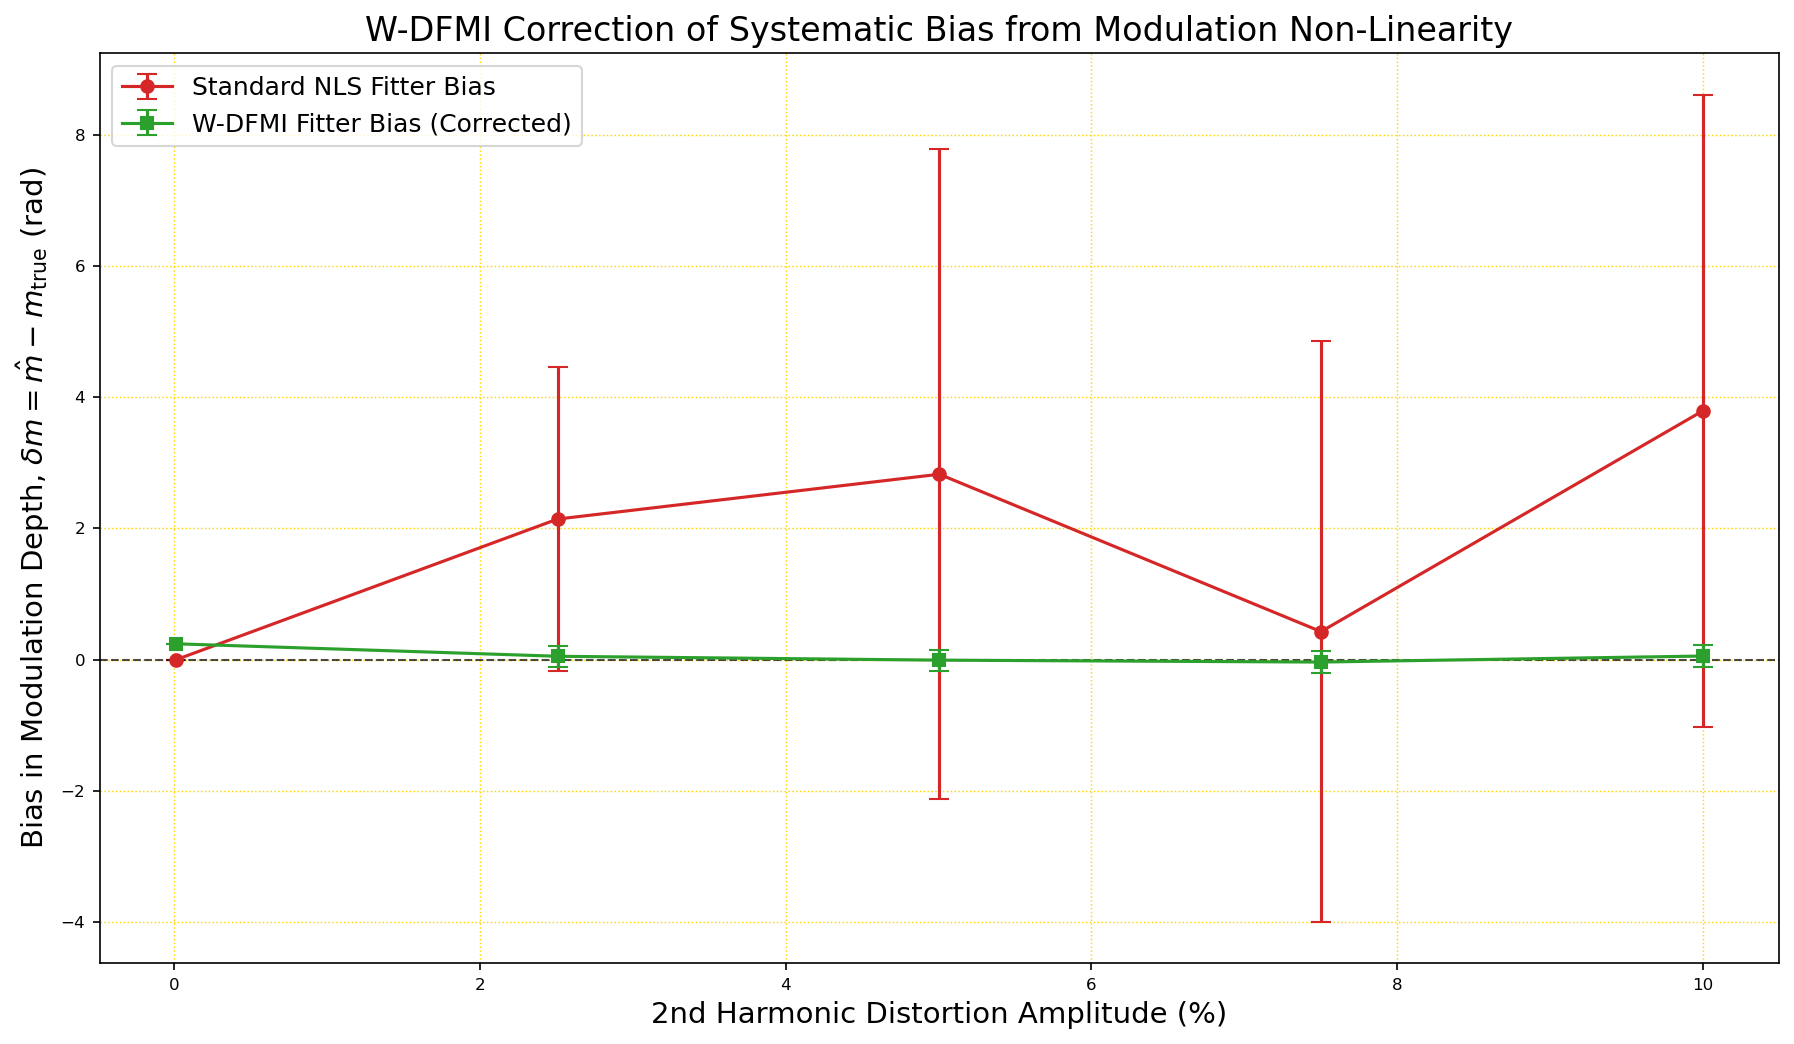

In [9]:
ax = validate_wdfmi_bias_correction(m_main=20.0, m_witness=0.04, ndata=50, distortion_range=np.linspace(0.0001, 0.1, 5), n_phase_trials=30)
plt.show()

In [ ]:
import DeepFMKit.core as dfm
import numpy as np
from tqdm import tqdm
import multiprocessing
import os

from DeepFMKit.workers import calculate_bias_for_point, calculate_bias_for_point_2

def generate_full_bias_landscape_parallel(
    m_range=np.linspace(2, 25, 32),
    distortion_range=np.linspace(0, 0.2, 32),
    n_phase_trials=100,
    m_witness=0.05,
    n_cores=None
):
    """
    Computes the data for a comprehensive 4-panel landscape plot in parallel.

    This function distributes the grid point calculations across multiple CPU
    cores to efficiently compute the mean and worst-case systematic bias for
    both the standard NLS and W-DFMI fitters over a range of modulation depths
    and distortion amplitudes. It does not perform any plotting.

    Parameters
    ----------
    m_range : array_like, optional
        The range of modulation depths (m) to simulate.
    distortion_range : array_like, optional
        The range of fractional distortion amplitudes (epsilon) to simulate.
    n_phase_trials : int, optional
        The number of random phase trials for the distortion at each grid point.
    m_witness : float, optional
        The target modulation depth for the witness channel.
    n_cores : int, optional
        Number of CPU cores to use. If None, uses all available cores.

    Returns
    -------
    dict
        A dictionary containing all the data required for plotting:
        - "m_range": The array of modulation depths used.
        - "distortion_range": The array of distortion amplitudes used.
        - "mean_std_bias_grid": 2D grid of the mean bias for the standard fitter.
        - "worst_std_bias_grid": 2D grid of the worst-case bias for the standard fitter.
        - "mean_wdfmi_bias_grid": 2D grid of the mean bias for the W-DFMI fitter.
        - "worst_wdfmi_bias_grid": 2D grid of the worst-case bias for the W-DFMI fitter.
    """
    if n_cores is None:
        n_cores = os.cpu_count()
        print(f"Using all available {n_cores} CPU cores.")
        
    print("=" * 60)
    print("Generating Full Bias Landscape Data (Parallel Version)")
    print(f"Grid size: {len(m_range)} (m) x {len(distortion_range)} (eps)")
    print("=" * 60)
    
    jobs = []
    for j, m_main in enumerate(m_range):
        for i, eps in enumerate(distortion_range):
            jobs.append({
                'm_main': m_main, 'epsilon': eps, 'n_phase_trials': n_phase_trials,
                'm_witness': m_witness, 'grid_i': i, 'grid_j': j
            })

    grid_shape = (len(distortion_range), len(m_range))
    mean_std_bias_grid = np.zeros(grid_shape)
    worst_std_bias_grid = np.zeros(grid_shape)
    mean_wdfmi_bias_grid = np.zeros(grid_shape)
    worst_wdfmi_bias_grid = np.zeros(grid_shape)

    with multiprocessing.Pool(processes=n_cores) as pool:
        results_iterator = pool.imap(calculate_bias_for_point_2, jobs)
        for result in tqdm(results_iterator, total=len(jobs), desc="Calculating Grid Points"):
            i, j, mean_std, worst_std, mean_wdfmi, worst_wdfmi = result
            mean_std_bias_grid[i, j] = mean_std
            worst_std_bias_grid[i, j] = worst_std
            mean_wdfmi_bias_grid[i, j] = mean_wdfmi
            worst_wdfmi_bias_grid[i, j] = worst_wdfmi

    print("\nAll calculations complete. Returning data grids.")
    
    # Package all results into a single dictionary for a clean return
    results = {
        "m_range": m_range,
        "distortion_range": distortion_range,
        "mean_std_bias_grid": mean_std_bias_grid,
        "worst_std_bias_grid": worst_std_bias_grid,
        "mean_wdfmi_bias_grid": mean_wdfmi_bias_grid,
        "worst_wdfmi_bias_grid": worst_wdfmi_bias_grid
    }
    
    return results

In [ ]:
# This cell might take a long time to run
if __name__ == "__main__":
    bias_results = generate_full_bias_landscape_parallel(
        m_witness=0.01,
        m_range=np.linspace(3, 25, 32),
        distortion_range=np.linspace(0, 0.2, 32),
        n_phase_trials=100
    )
    import pickle
    with open('bias_landscape_results.pkl', 'wb') as f:
        pickle.dump(bias_results, f)

In [ ]:
def plot_bias_landscape(results):
    """
    Plots the comprehensive 4-panel bias landscape figure.

    This function takes the pre-computed data grids and generates the final
    figure for publication, separating the visualization from the long-running
    simulation task.

    Parameters
    ----------
    results : dict
        A dictionary containing the computed grids and axes, as returned by
        `generate_full_bias_landscape_parallel`.
    """
    # --- 1. Unpack the results dictionary ---
    m_range = results["m_range"]
    distortion_range = results["distortion_range"]
    mean_std_bias_grid = results["mean_std_bias_grid"]
    worst_std_bias_grid = results["worst_std_bias_grid"]
    mean_wdfmi_bias_grid = results["mean_wdfmi_bias_grid"]
    worst_wdfmi_bias_grid = results["worst_wdfmi_bias_grid"]
    
    # --- 2. Setup the Figure and Axes ---
    fig = plt.figure(figsize=(18, 14))
    gs = GridSpec(2, 3, width_ratios=[1, 1, 0.05], wspace=0.3, hspace=0.4)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    cax = fig.add_subplot(gs[:, 2])
    
    # --- 3. Prepare data for plotting ---
    # Define a custom colormap
    colors = ["#FFFFFF", "#D6EAF8", "#5499C7", "#154360"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    
    # Determine a common color scale limit
    vmax = np.pi

    # Calculate the phi_error_grid for the contour lines
    temp_ifo_config = dfm.InterferometerConfig()
    opd = temp_ifo_config.meas_arml - temp_ifo_config.ref_arml
    delta_f_range = (m_range * dfm.sc.c) / (2 * np.pi * opd)
    f0 = dfm.sc.c / 1.064e-6
    m_to_phi_error_factor = f0 / delta_f_range
    
    phi_error_grid_mean = np.abs(mean_std_bias_grid) * m_to_phi_error_factor
    phi_error_grid_worst = np.abs(worst_std_bias_grid) * m_to_phi_error_factor

    # --- 4. Plotting Panels ---
    def plot_panel(ax, data, title, show_contour=False, contour_data=None):
        im = ax.pcolormesh(m_range, distortion_range * 100, np.abs(data), 
                           cmap=custom_cmap, vmin=0, vmax=vmax, shading='auto')
        if show_contour:
            # contour = ax.contour(m_range, distortion_range * 100, contour_data, 
            #                      levels=[np.pi], colors='red', linewidths=2, linestyles='--')
            ax.plot([], [], color='red', linestyle='--', linewidth=2, label=r'$|\delta\Phi_{\rm coarse}| = \pi$')
            # ax.legend(loc='upper right', fontsize=12)
        ax.set_title(title, fontsize=16, pad=10)
        ax.set_xlabel(r'Modulation Depth, $m$', fontsize=14)
        ax.set_ylabel(r'2nd Harmonic Distortion, $\epsilon$ (%)', fontsize=14)
        ax.grid(False)
        return im

    im = plot_panel(ax1, mean_std_bias_grid, '(a) Standard NLS: Mean Bias', True, phi_error_grid_mean)
    plot_panel(ax2, mean_wdfmi_bias_grid, '(b) W-DFMI: Mean Bias (Corrected)')
    plot_panel(ax3, worst_std_bias_grid, '(c) Standard NLS: Worst-Case Bias', True, phi_error_grid_worst)
    plot_panel(ax4, worst_wdfmi_bias_grid, '(d) W-DFMI: Worst-Case Bias (Corrected)')

    fig.colorbar(im, cax=cax, orientation='vertical', label=r'Absolute Bias, $|\delta m|$ (rad)')
    
    plt.show()

In [ ]:
plot_bias_landscape(bias_results)

In [ ]:
def generate_witness_interaction_data(
    m_main_range=np.linspace(3, 25, 100),
    m_witness_range=np.linspace(0.01, 0.1, 100),
    witness_ifo_phase=None,
    n_cores=None
):
    """
    Computes the W-DFMI bias landscape for a non-distorted signal.
    This version is safe to run from a Jupyter Notebook.
    """
    if n_cores is None:
        n_cores = os.cpu_count()
        
    print("=" * 60)
    print("Generating Witness Interaction Bias Landscape (No Distortion)")
    print(f"Grid size: {len(m_main_range)} (m_main) x {len(m_witness_range)} (m_witness)")
    print("=" * 60)
    
    jobs = []
    for j, m_main in enumerate(m_main_range):
        for i, m_witness in enumerate(m_witness_range):
            jobs.append({
                'm_main': m_main, 'm_witness': m_witness,
                'witness_phi': witness_ifo_phase,
                'grid_i': i, 'grid_j': j
            })

    grid_shape = (len(m_witness_range), len(m_main_range))
    bias_grid = np.zeros(grid_shape)

    # This check is good practice for notebook environments
    if __name__ == "__main__":
        with multiprocessing.Pool(processes=n_cores) as pool:
            results_iterator = pool.imap(calculate_bias_for_m_vs_mwitness, jobs)
            for result in tqdm(results_iterator, total=len(jobs), desc="Calculating Grid Points"):
                i, j, bias = result
                bias_grid[i, j] = bias
            
    results = {
        "m_main_range": m_main_range,
        "m_witness_range": m_witness_range,
        "bias_grid": bias_grid,
        "witness_ifo_phase": witness_ifo_phase
    }
    
    return results


In [ ]:
if __name__ == "__main__":
    interaction_results = generate_witness_interaction_data(witness_ifo_phase=0.1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

def plot_witness_interaction_landscape(results):
    """
    Plots the W-DFMI bias landscape for a non-distorted signal.
    """
    m_main_range = results["m_main_range"]
    m_witness_range = results["m_witness_range"]
    bias_grid = results["bias_grid"]
    if results["witness_ifo_phase"] is None:
        phase_rad = '(self-aligned)'
    else:
        phase_rad = results["witness_ifo_phase"]
    
    fig, ax = plt.subplots(figsize=(12, 9))

    max_abs_bias = np.max(np.abs(bias_grid))
    max_abs_bias = np.pi
    norm = Normalize(vmin=0, vmax=max_abs_bias)  # Linear color scale

    im = ax.pcolormesh(
        m_main_range, m_witness_range, np.abs(bias_grid),
        cmap='coolwarm', norm=norm, shading='auto'
    )
    
    ax.set_title(f'W-DFMI Residual Bias (No Distortion), Witness phase = {phase_rad}', fontsize=16)
    ax.set_xlabel(r'Main Modulation Depth, $m_{\rm main}$', fontsize=14)
    ax.set_ylabel(r'Witness Modulation Depth, $m_{\rm witness}$', fontsize=14)
    
    fig.colorbar(im, ax=ax, label=r'Residual Bias, $\delta m$ (rad)')
    
    plt.show()

# --- Load and plot the results ---
# import pickle
# with open('interaction_results.pkl', 'rb') as f:
#     interaction_results = pickle.load(f)

# The 'interaction_results' variable should be available from the cell above
plot_witness_interaction_landscape(interaction_results)

In [ ]:
import numpy as np
import scipy.special as sc
import matplotlib.pyplot as plt

def compute_and_plot_problematic_m(max_order=5, num_roots=10, m_limit=25):
    """
    Computes and visualizes the problematic modulation depths ('dead zones')
    for DFMI, which correspond to the roots of low-order Bessel functions.

    This function calculates the first `num_roots` zeros for each Bessel
    function from order 0 to `max_order`. It then generates a plot that
    clearly marks these `m` values, providing a guide for selecting robust
    operating points in a DFMI experiment.

    Parameters
    ----------
    max_order : int, optional
        The maximum harmonic order (n) of the Bessel functions to analyze.
        Defaults to 5, as higher orders have less impact.
    num_roots : int, optional
        The number of roots (zeros) to find for each Bessel function order.
    m_limit : float, optional
        The maximum value of 'm' to display on the plot's x-axis.
    """
    print("=" * 60)
    print("Calculating Problematic 'm' Values (Bessel Function Zeros)")
    print("=" * 60)
    
    # Store roots in a dictionary: {order: [root1, root2, ...]}
    bessel_zeros = {}
    
    for n in range(max_order + 1):
        # Use scipy.special.jn_zeros to find the first `num_roots` zeros
        # of the n-th order Bessel function of the first kind.
        zeros = sc.jn_zeros(n, num_roots)
        bessel_zeros[n] = zeros
        print(f"Zeros for J_{n}(m): {np.round(zeros, 2)}")
        
    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(15, 3))
    
    colors = plt.cm.viridis(np.linspace(0, 1, max_order + 1))
    
    # Plot a vertical line for each root
    for order, zeros in bessel_zeros.items():
        for i, root in enumerate(zeros):
            if root > m_limit:
                continue
            # Make the first line for each order solid, others dashed
            linestyle = '-' if i == 0 else '--'
            # Use the first line to create the legend entry
            label = f'Zeros of $J_{order}(m)$' if i == 0 else None
            ax.axvline(x=root, color=colors[order], linestyle=linestyle, label=label, alpha=0.8)

    ax.set_title('DFMI "Dead Zones": Zeros of Low-Order Bessel Functions', fontsize=16)
    ax.set_xlabel('Modulation Depth, $m$', fontsize=14)
    ax.set_yticks([]) # This axis has no meaning, so we remove the ticks
    ax.set_xlim(0, m_limit)
    ax.legend(loc='center right')
    ax.grid(axis='x', linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

# --- Run the function to generate the plot ---
if __name__ == "__main__":
    compute_and_plot_problematic_m(max_order=5, num_roots=10, m_limit=25)

In [ ]:
import numpy as np
import scipy.special as sc
import matplotlib.pyplot as plt

def analyze_witness_sensitivity(
    witness_m_range=np.linspace(0.1, 8, 500),
    regularization=1e-10
):
    """
    Analyzes and visualizes the sensitivity of the W-DFMI witness channel.

    This function demonstrates that the W-DFMI technique can fail if the witness
    interferometer is "blind" to the specific harmonic distortion present in
    the laser. For the case of 2nd harmonic distortion, this occurs when the
    witness modulation depth, `m_witness`, is near a root of the 2nd-order
    Bessel function, J2(m).

    The function plots an instability metric, 1/|J2(m_witness)|^2, which peaks
    sharply at these "bad witness" values.

    Parameters
    ----------
    witness_m_range : array_like, optional
        The range of witness modulation depths to analyze.
    regularization : float, optional
        A small value added to prevent division by zero in the metric.
    """
    print("=" * 60)
    print("Analyzing W-DFMI Witness Sensitivity to 2nd Harmonic Distortion")
    print("=" * 60)

    # --- 1. Calculate the J2(m) function for the witness range ---
    j2_values = sc.jn(2, witness_m_range)

    # --- 2. Calculate the Instability Metric ---
    # The metric explodes when J2(m) is close to zero.
    instability_metric = 1 / (j2_values**2 + regularization)

    # --- 3. Find the roots of J2(m) to mark on the plot ---
    j2_roots = sc.jn_zeros(2, 5) # Find the first 5 roots of J2

    # --- 4. Plotting ---
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the instability metric
    ax.semilogy(witness_m_range, instability_metric, color='tab:red', linewidth=2.5,
                label=r'Predicted Instability $\propto 1 / |J_2(m_{\rm witness})|^2$')

    # Mark the locations of the J2 roots
    for root in j2_roots:
        if root < witness_m_range[-1]:
            ax.axvline(x=root, color='k', linestyle='--', alpha=0.8,
                       label=r'$J_2(m) = 0$ at $m \approx {root:.2f}$')

    ax.set_title('W-DFMI Fitter Instability vs. Witness Modulation Depth', fontsize=16)
    ax.set_xlabel(r'Witness Modulation Depth, $m_{\rm witness}$', fontsize=14)
    ax.set_ylabel('Predicted Instability (Log Scale)', fontsize=14)
    ax.set_xlim(witness_m_range[0], witness_m_range[-1])
    ax.set_ylim(bottom=1, top=1e8) # Adjust top limit if needed
    ax.grid(True, which='both', linestyle=':')
    ax.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

# --- Run the function to generate the plot ---
if __name__ == "__main__":
    analyze_witness_sensitivity()

In [ ]:
import DeepFMKit.core as dfm
import numpy as np
from tqdm import tqdm
import multiprocessing
import os
import scipy.special as sc

from DeepFMKit.workers import calculate_bias_for_point

def get_dead_zones(max_order=5, num_roots=10, tolerance=0.25):
    """
    Calculates a list of problematic m-value ranges to avoid.

    Returns a list of tuples, where each tuple is a (min, max) range
    representing a dead zone.
    """
    dead_zones = []
    for n in range(max_order + 1):
        zeros = sc.jn_zeros(n, num_roots)
        for root in zeros:
            dead_zones.append((root - tolerance, root + tolerance))
    return dead_zones

def is_in_dead_zone(m_value, dead_zones):
    """Checks if a given m_value falls within any of the dead zones."""
    for low, high in dead_zones:
        if low <= m_value <= high:
            return True
    return False

def generate_smart_landscape_data_parallel(
    m_min=3, m_max=25, m_points=32,
    distortion_range=np.linspace(0, 0.2, 16),
    n_phase_trials=20,
    m_witness=0.05,
    n_cores=None
):
    """
    Computes the data for a W-DFMI bias landscape on a "smart" grid that avoids dead zones.

    This function performs the parallel simulation and returns a dictionary of
    results suitable for later plotting. It does not generate any figures itself.

    Parameters
    ----------
    m_min, m_max, m_points : float, int
        Define the range and resolution of the modulation depth axis to scan.
    distortion_range : array_like, optional
        The range of fractional distortion amplitudes (epsilon) to simulate.
    n_phase_trials : int, optional
        The number of random phase trials for the distortion at each grid point.
    m_witness : float, optional
        The target modulation depth for the witness channel.
    n_cores : int, optional
        Number of CPU cores to use. If None, uses all available cores.

    Returns
    -------
    dict
        A dictionary containing all the data required for plotting, including
        the pruned "smart" m_range and the resulting bias grid.
    """
    if n_cores is None:
        n_cores = os.cpu_count()
        print(f"Using all available {n_cores} CPU cores.")
    
    # --- 1. Identify and Prune the m_range ---
    dead_zones = get_dead_zones(max_order=5, num_roots=10, tolerance=0.25)
    full_m_range = np.linspace(m_min, m_max, m_points)
    smart_m_range = [m for m in full_m_range if not is_in_dead_zone(m, dead_zones)]
    
    print("=" * 60)
    print("Generating 'Smart' Bias Landscape Data (Avoiding Dead Zones)")
    print(f"Original m-points: {len(full_m_range)}. Pruned m-points: {len(smart_m_range)}")
    print("=" * 60)
    
    # --- 2. Create the list of jobs for the smart grid ---
    jobs = []
    for j, m_main in enumerate(smart_m_range):
        for i, eps in enumerate(distortion_range):
            jobs.append({
                'm_main': m_main, 'epsilon': eps, 'n_phase_trials': n_phase_trials,
                'm_witness': m_witness, 'grid_i': i, 'grid_j': j
            })

    grid_shape = (len(distortion_range), len(smart_m_range))
    worst_wdfmi_bias_grid = np.zeros(grid_shape)

    # --- 3. Run the simulation in parallel ---
    with multiprocessing.Pool(processes=n_cores) as pool:
        results_iterator = pool.imap(calculate_bias_for_point, jobs)
        for result in tqdm(results_iterator, total=len(jobs), desc="Calculating 'Smart' Grid Points"):
            # We only need the worst-case wdfmi bias for this plot
            i, j, _, _, _, worst_wdfmi = result
            worst_wdfmi_bias_grid[i, j] = worst_wdfmi
    
    print("\nAll calculations complete. Returning data.")
    
    # Package all results into a single dictionary
    results = {
        "smart_m_range": np.array(smart_m_range),
        "distortion_range": distortion_range,
        "worst_wdfmi_bias_grid": worst_wdfmi_bias_grid
    }
    
    return results

In [ ]:
# This cell will run the parallel computation and store the results.
# It might take some time.
if __name__ == "__main__":
    smart_results = generate_smart_landscape_data_parallel(
        m_witness=0.04,
        m_points=64, # Increase resolution for a nicer plot
        distortion_range=np.linspace(0, 0.2, 21)
    )
    import pickle
    with open('smart_landscape_results.pkl', 'wb') as f:
        pickle.dump(smart_results, f)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

def plot_smart_landscape(results):
    """
    Plots the W-DFMI bias landscape on the pruned "smart" grid.

    This function takes the pre-computed data and generates a two-panel
    figure showing the final, corrected performance of the W-DFMI technique.

    Parameters
    ----------
    results : dict
        A dictionary containing the computed grids and axes, as returned by
        `generate_smart_landscape_data_parallel`.
    """
    # --- 1. Unpack the results dictionary ---
    smart_m_range = results["smart_m_range"]
    distortion_range = results["distortion_range"]
    worst_wdfmi_bias_grid = results["worst_wdfmi_bias_grid"]
    
    # --- 2. Setup the Figure ---
    fig = plt.figure(figsize=(18, 7))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.7], wspace=0.3)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax1.grid(False)
    ax2.grid(False)

    colors = ["#FFFFFF", "#D6EAF8", "#5499C7", "#154360"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    # --- 3. Panel (a): The "Smart" Landscape ---
    # Use a small vmax to highlight any small residual bias
    vmax = np.pi
    im = ax1.pcolormesh(smart_m_range, distortion_range * 100, np.abs(worst_wdfmi_bias_grid),
                        cmap=custom_cmap, vmin=0, vmax=vmax, shading='auto')
    ax1.set_title('(a) W-DFMI Worst-Case Bias on a "Smart" Grid', fontsize=16, pad=10)
    ax1.set_xlabel(r'Modulation Depth, $m$ (non-dead-zone values)', fontsize=14)
    ax1.set_ylabel(r'2nd Harmonic Distortion, $\epsilon$ (%)', fontsize=14)
    fig.colorbar(im, ax=ax1, orientation='vertical', label=r'Worst-Case Absolute Bias, $|\delta m|_{\rm max}$ (rad)')

    # --- 4. Panel (b): 1D Slice for a robust operating point ---
    # Find a good m value around 15.5 to plot
    target_m = 17.0
    if len(smart_m_range) > 0:
        closest_m_index = np.argmin(np.abs(smart_m_range - target_m))
        m_slice = smart_m_range[closest_m_index]
        bias_slice = worst_wdfmi_bias_grid[:, closest_m_index]

        ax2.plot(distortion_range * 100, bias_slice, 's-', color='tab:green')
        ax2.axhline(0, color='k', linestyle='--', alpha=0.6)
        ax2.set_title(f'(b) 1D Slice at Robust Operating Point (m ≈ {m_slice:.1f})', fontsize=16, pad=10)
        ax2.set_xlabel(r'2nd Harmonic Distortion, $\epsilon$ (%)', fontsize=14)
        ax2.set_ylabel(r'Worst-Case Absolute Bias, $|\delta m|_{\rm max}$ (rad)', fontsize=14)
        ax2.grid(True, linestyle=':')
        ax2.set_ylim(-vmax, vmax) # Use same scale as colormap for consistency
    else:
        ax2.text(0.5, 0.5, "No 'smart' m-values found in range.",
                 ha='center', va='center', transform=ax2.transAxes)

    plt.tight_layout()
    plt.show()
    
plot_smart_landscape(smart_results)